<a href="https://colab.research.google.com/github/swarubm/thyroid-MP/blob/main/thyroid%20final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np


In [4]:

# Load the dataset
df = pd.read_csv('/content/hypothyroid (3).csv')
print(df.shape)             # 3772 rows, 30 columns

(3772, 30)


In [5]:
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41,F,f,f,f,f,f,f,f,f,...,t,125,t,1.14,t,109,f,?,SVHC,negative
1,23,F,f,f,f,f,f,f,f,f,...,t,102,f,?,f,?,f,?,other,negative
2,46,M,f,f,f,f,f,f,f,f,...,t,109,t,0.91,t,120,f,?,other,negative
3,70,F,t,f,f,f,f,f,f,f,...,t,175,f,?,f,?,f,?,other,negative
4,70,F,f,f,f,f,f,f,f,f,...,t,61,t,0.87,t,70,f,?,SVI,negative


In [6]:

print(df.shape)             # 3772 rows, 30 columns
print(df['Class'].value_counts())  # Check class distribution

# Replace '?' with NaN and drop columns with all or many missing values
df = df.replace('?', np.nan)
df.drop(columns=['TBG_measured','TBG','referral_source','TSH_measured','T3_measured','TT4_measured','T4U_measured','FTI_measured'], inplace=True)

# Map binary features 't'/'f' to 1/0
binary_cols = ['on_thyroxine','query_on_thyroxine','on_antithyroid_medication','sick',
               'pregnant','thyroid_surgery','I131_treatment','query_hypothyroid',
               'query_hyperthyroid','lithium','goitre','tumor','hypopituitary','psych']
for col in binary_cols:
    df[col] = df[col].map({'t':1,'f':0})
# Convert sex to numeric (M=1, F=0), imputing missing with mode
df['sex'] = df['sex'].map({'M':1,'F':0})
df['sex'].fillna(df['sex'].mode()[0], inplace=True)

# Convert numeric columns to float
num_cols = ['age','TSH','T3','TT4','T4U','FTI']
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows still having missing target or too many missing features (if any)
df.dropna(subset=['Class'], inplace=True)

# Create binary target: 0 = negative (no disease), 1 = any hypothyroid condition
df['disease'] = (df['Class'] != 'negative').astype(int)
df.drop(columns=['Class'], inplace=True)
print("Shape after cleaning:", df.shape)
print(df.isnull().sum())  # Check remaining missing values


(3772, 30)
Class
negative                   3481
compensated_hypothyroid     194
primary_hypothyroid          95
secondary_hypothyroid         2
Name: count, dtype: int64
Shape after cleaning: (3772, 22)
age                            1
sex                            0
on_thyroxine                   0
query_on_thyroxine             0
on_antithyroid_medication      0
sick                           0
pregnant                       0
thyroid_surgery                0
I131_treatment                 0
query_hypothyroid              0
query_hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH                          369
T3                           769
TT4                          231
T4U                          387
FTI                          385
disease                        0
dtype: int64


/tmp/ipython-input-3855670756.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('?', np.nan)
/tmp/ipython-input-3855670756.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['sex'].fillna(df['sex'].mode()[0], inplace=True)


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Class imbalance
print(df['disease'].value_counts())
# Feature statistics
print(df.describe())
# Check correlation of numeric features
corr = df[num_cols + ['TSH','T3','TT4','T4U']].corr()
print("Correlation matrix:\n", corr.round(2))


disease
0    3481
1     291
Name: count, dtype: int64
               age          sex  on_thyroxine  query_on_thyroxine  \
count  3771.000000  3772.000000   3772.000000         3772.000000   
mean     51.735879     0.302757      0.123012            0.013256   
std      20.084958     0.459512      0.328494            0.114382   
min       1.000000     0.000000      0.000000            0.000000   
25%      36.000000     0.000000      0.000000            0.000000   
50%      54.000000     0.000000      0.000000            0.000000   
75%      67.000000     1.000000      0.000000            0.000000   
max     455.000000     1.000000      1.000000            1.000000   

       on_antithyroid_medication         sick     pregnant  thyroid_surgery  \
count                3772.000000  3772.000000  3772.000000      3772.000000   
mean                    0.011400     0.038971     0.014051         0.014051   
std                     0.106174     0.193552     0.117716         0.117716   
min     

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_features = ['age','TSH','T3','TT4','T4U']
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_features = ['sex']
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


In [9]:
from sklearn.model_selection import train_test_split

X = df[numeric_features + ['sex'] + binary_cols]  # features after cleaning
y = df['disease']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train set class distribution:", y_train.value_counts(normalize=True).to_dict())
print("Test set class distribution:", y_test.value_counts(normalize=True).to_dict())


Train set class distribution: {0: 0.9227709645343056, 1: 0.0772290354656944}
Test set class distribution: {0: 0.9231788079470199, 1: 0.07682119205298013}


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Define pipelines
pipe_lr = Pipeline([('prep', preprocessor), ('clf', LogisticRegression(max_iter=1000))])
pipe_rf = Pipeline([('prep', preprocessor), ('clf', RandomForestClassifier(n_estimators=100, random_state=42))])
pipe_xgb = Pipeline([('prep', preprocessor), ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))])

# Train models
for name, pipe in [("Logistic Regression", pipe_lr),
                   ("Random Forest", pipe_rf),
                   ("XGBoost", pipe_xgb)]:
    pipe.fit(X_train, y_train)
    print(f"{name} trained.")


Logistic Regression trained.
Random Forest trained.
XGBoost trained.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:28:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

models = {"LogisticRegression": pipe_lr, "RandomForest": pipe_rf, "XGBoost": pipe_xgb}
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\n{name} evaluation:")
    print(" Accuracy:", accuracy_score(y_test, y_pred))
    print(" Precision:", precision_score(y_test, y_pred))
    print(" Recall:", recall_score(y_test, y_pred))
    print(" F1-score:", f1_score(y_test, y_pred))
    # ROC-AUC (binary)
    y_proba = model.predict_proba(X_test)[:,1]
    print(" ROC-AUC:", roc_auc_score(y_test, y_proba))
    print(" Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



LogisticRegression evaluation:
 Accuracy: 0.952317880794702
 Precision: 0.84375
 Recall: 0.46551724137931033
 F1-score: 0.6
 ROC-AUC: 0.9740266165339138
 Confusion Matrix:
 [[692   5]
 [ 31  27]]

RandomForest evaluation:
 Accuracy: 0.9814569536423841
 Precision: 0.8235294117647058
 Recall: 0.9655172413793104
 F1-score: 0.8888888888888888
 ROC-AUC: 0.9935932320783654
 Confusion Matrix:
 [[685  12]
 [  2  56]]

XGBoost evaluation:
 Accuracy: 0.9788079470198675
 Precision: 0.85
 Recall: 0.8793103448275862
 F1-score: 0.864406779661017
 ROC-AUC: 0.9927274526294958
 Confusion Matrix:
 [[688   9]
 [  7  51]]


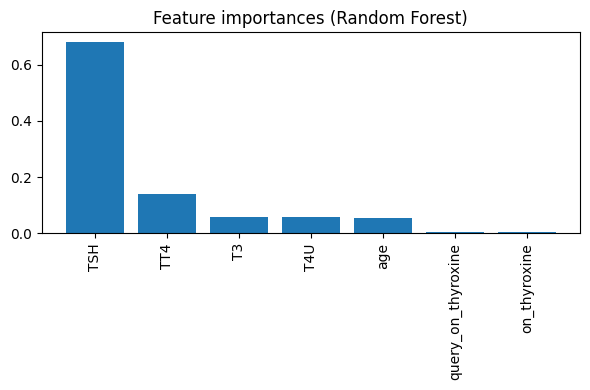

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature names after one-hot encoding (sex) and original order
ohe = pipe_rf.named_steps['prep'].named_transformers_['cat'].named_steps['onehot']
feat_names = numeric_features + list(binary_cols) + ['sex_M']  # sex encoded as one column
importances = pipe_rf.named_steps['clf'].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(6,4))
plt.title("Feature importances (Random Forest)")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), np.array(feat_names)[indices], rotation=90)
plt.tight_layout()
plt.show()


In [13]:
import joblib
best_model = pipe_xgb  # suppose XGBoost was best
joblib.dump(best_model, 'thyroid_detection_pipeline.joblib')
print("Pipeline saved to 'thyroid_detection_pipeline.joblib'.")


Pipeline saved to 'thyroid_detection_pipeline.joblib'.


In [ ]:
from flask import Flask, request, jsonify
import joblib
import pandas as pd

app = Flask(__name__)
model = joblib.load('thyroid_detection_pipeline.joblib')  # load saved pipeline

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()  # expects JSON with feature values
    df = pd.DataFrame([data])
    prediction = model.predict(df)[0]
    return jsonify({'prediction': int(prediction)})

if __name__ == '__main__':
    app.run(port=5000)


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
